<a href="https://colab.research.google.com/github/naraquev/Private-AI/blob/master/research/Generative_Adversarial_Nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of:

Generative Adversarial Nets: https://arxiv.org/pdf/1406.2661.pdf


In [0]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, imsave
%matplotlib inline
import torch.nn.functional as F
from torch.autograd import Variable
import os
import pandas as pd

As the original paper states, the Generator and discriminators can be any feedforward network (There is no need of a CNN here)

In [0]:
class Generator(nn.Module):
   
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)        
        self.fc2 = nn.Linear(128,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512,1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, num_classes)
        self.lr1 = nn.LeakyReLU(0.2)
        self.lr2 = nn.LeakyReLU(0.2)
        self.lr3 = nn.LeakyReLU(0.2)
        self.lr4 = nn.LeakyReLU(0.2)      
        
        
    def forward(self, x):            
        x= self.fc1(x)
        x = self.lr1(x)
        x= self.bn2(self.fc2(x))
        x = self.lr2(x)
        x= self.bn3(self.fc3(x))
        x = self.lr3(x)
        x= self.bn4(self.fc4(x))
        x = self.lr4(x)
        x = self.fc5(x)
        x = torch.tanh(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self, img_size=28, channels=1, num_clas=10):
      super().__init__()
      self.fc1 = nn.Linear(img_size**2 * channels, 500)
      self.fc2 = nn.Linear(500, 400)
      self.fc3 = nn.Linear(400, 40)
      self.fc4 = nn.Linear(40, 10)
      self.fc5 = nn.Linear(10, 1)
    def forward(self, x):
      x = x.view(x.shape[0], 28*28*1)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.fc5(x)
      return torch.sigmoid(x)
    

We need the size of the code that is going to be the seed of the generator (The terminology is Z on the original paper)

In [0]:
code_len = 100
bsize = 64
epochs = 15
d_advantage = 2
device = torch.device("cuda:0""cuda:0" if torch.cuda.is_available() else "cpu")
D = Discriminator()
G = Generator(code_len)
G.to(device)
D.to(device)
criterion = torch.nn.BCELoss()
criterion.to(device)
dis_opti = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_opti = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [0]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, ), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', download=True, transform=transform)
loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=bsize, shuffle=True, drop_last=True)
D_reals = torch.ones(bsize, 1).to(device) 
D_fakes = torch.zeros(bsize, 1).to(device) 
if not os.path.exists('samples'):    
    os.makedirs('samples')
else:
  path = 'samples'
  os.system('rm -rf %s/*' % path)
clear_output()

In [11]:
step = 0
G.train()
D.train()

for e in range(epochs):   
  print('Epoch: ', e)
  dis_running_loss = 0
  gen_running_loss = 0
  #step = 0
  for idx, (images, clas) in enumerate(loader):
   
    #Generator Images
    z = torch.randn(bsize, code_len).to(device) 
    z_output = D(G(z))
    D_loss_z = criterion(z_output, D_fakes)
    
    
    #Real Images
    x = images.to(device)
    x_output = D(x)
    D_loss_x = criterion(x_output, D_reals)
        
    #Acumulating the losses
    D_loss = D_loss_z + D_loss_x
    
    #BackProp
    dis_opti.zero_grad()   
    D_loss.backward()
    dis_opti.step() 
    
    #Acumulating loss for the epoch
    dis_running_loss+= D_loss.item()
    
    #Generator Training
    if(step % d_advantage == 0):
      z = torch.randn(bsize, code_len).to(device)       
      z_output = D(G(z))
      G_loss = criterion(z_output, D_reals)
      gen_opti.zero_grad()   
      G_loss.backward()
      gen_opti.step()
      gen_running_loss += G_loss.item()
    
    
    #Print Progress
    if step % 500 == 0:
       print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(e, epochs, step, dis_running_loss, gen_running_loss))
    #Save images for latter debuging 
    if step % 5000 == 0:
            G.eval()
            #Creating a 10 by 10 layout for the 28x28 images
            img = np.zeros([280, 280])   
            for j in range(10):              
              z = torch.randn(10, code_len).to(device)
              y_hat = G(z).view(10, 28, 28) # (10, 28, 28)
              result = y_hat.cpu().data.numpy()                       
              img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)              
              imsave('samples/{}_step{}.jpg'.format('Simple_GAN', str(step).zfill(3)), img, cmap='gray')
            G.train()
    step +=1


Epoch:  0
Epoch: 0/15, Step: 0, D Loss: 1.3451699018478394, G Loss: 0.7365461587905884
Epoch: 0/15, Step: 500, D Loss: 525.8448473215103, G Loss: 216.87559574842453
Epoch:  1
Epoch: 1/15, Step: 1000, D Loss: 44.5643575489521, G Loss: 44.11442619562149
Epoch: 1/15, Step: 1500, D Loss: 361.5799296796322, G Loss: 471.39662715792656
Epoch:  2
Epoch: 2/15, Step: 2000, D Loss: 77.94947469234467, G Loss: 124.14500749111176
Epoch: 2/15, Step: 2500, D Loss: 389.47230580449104, G Loss: 619.4991167783737
Epoch:  3
Epoch: 3/15, Step: 3000, D Loss: 121.74237358570099, G Loss: 187.85858809947968
Epoch: 3/15, Step: 3500, D Loss: 460.10432401299477, G Loss: 664.0316194295883
Epoch:  4
Epoch: 4/15, Step: 4000, D Loss: 168.38491502404213, G Loss: 245.0297577381134
Epoch: 4/15, Step: 4500, D Loss: 508.91278263926506, G Loss: 718.5824655294418
Epoch:  5
Epoch: 5/15, Step: 5000, D Loss: 224.29869836568832, G Loss: 291.2255038022995
Epoch: 5/15, Step: 5500, D Loss: 576.793114811182, G Loss: 748.641571640968

KeyboardInterrupt: ignored

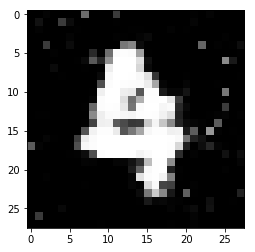

In [12]:
G.eval()
z = torch.randn(1, code_len).to(device)
img = G(z).view(1, 28, 28)
plt.imshow(img[0].cpu().data.numpy(), cmap="Greys_r", interpolation="none")

In [13]:
!ls ./samples


Simple_GAN_step000.jpg	Simple_GAN_step10000.jpg  Simple_GAN_step5000.jpg


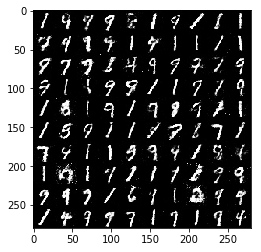

In [14]:
import matplotlib.image as mpimg
image = mpimg.imread('./samples/Simple_GAN_step10000.jpg')
plt.imshow(image)

In [0]:
from google.colab import files
path = './samples'
list_f = os.listdir(path)
for file in list_f:
  files.download(os.path.join(path, file)) 

GAN's are also used for unsupervised learning. For this task is important that the generator generates an image from a given class. That's wher the conditional GAN takes relevance:

Conditional GAN: https://arxiv.org/pdf/1411.1784.pdf
https://arxiv.org/pdf/1511.06434.pdf

The idea is to concatenate the class with the random code to the generator

In [0]:
class generator(nn.Module):
   
    def __init__(self, input_size=100,condition_size = 10, num_classes=784):
        super(generator, self).__init__()
        self.fc1 = nn.Linear(input_size+condition_size, 128)        
        self.fc2 = nn.Linear(128,256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256,512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512,1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, num_classes)
        self.lr1 = nn.LeakyReLU(0.2)
        self.lr2 = nn.LeakyReLU(0.2)
        self.lr3 = nn.LeakyReLU(0.2)
        self.lr4 = nn.LeakyReLU(0.2)      
        
        
    def forward(self, x, c):  
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1)
        v = torch.cat((x, c), 1)        
        x= self.fc1(v)
        x = self.lr1(x)
        x= self.bn2(self.fc2(x))
        x = self.lr2(x)
        x= self.bn3(self.fc3(x))
        x = self.lr3(x)
        x= self.bn4(self.fc4(x))
        x = self.lr4(x)
        x = self.fc5(x)
        x = torch.tanh(x)
        x = x.view(x.size(0), 1, 28, 28)
        return x

In [0]:
class discriminator(nn.Module):
    def __init__(self, img_size=28, channels=1, num_clas=10):
      super().__init__()
      self.fc1 = nn.Linear((img_size**2 * channels)+num_clas, 500)
      self.fc2 = nn.Linear(500, 400)
      self.fc3 = nn.Linear(400, 40)
      self.fc4 = nn.Linear(40, 10)
      self.fc5 = nn.Linear(10, 1)
    def forward(self, x, c):
      x = x.view(x.shape[0], 28*28*1)
      v = torch.cat((x, c), 1)
      x = F.relu(self.fc1(v))
      x = F.relu(self.fc2(x))
      x = F.relu(self.fc3(x))
      x = F.relu(self.fc4(x))
      x = self.fc5(x)
      return torch.sigmoid(x)

In [0]:
CD = discriminator()
CG = generator()
CG.to(device)
CD.to(device)
criterion = torch.nn.BCELoss()
criterion.to(device)
dis_opti = torch.optim.Adam(CD.parameters(), lr=0.0002, betas=(0.5, 0.999))
gen_opti = torch.optim.Adam(CG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [28]:
step = 0
CG.train()
CD.train()

for e in range(epochs):   
  print('Epoch: ', e)
  dis_running_loss = 0
  gen_running_loss = 0
  #step = 0
  for idx, (images, clas) in enumerate(loader):
   
    #Generator Images
    z = torch.randn(bsize, code_len).to(device) 
    clas = clas.cpu()
    clas = clas.view(bsize, 1)
    c = torch.FloatTensor(clas.size(0), 10)
    c.zero_()
    c.scatter_(1, clas, 1)
    c =c.to(device) 
    z_output = CD(CG(z, c),c)
    D_loss_z = criterion(z_output, D_fakes)
    
    
    #Real Images
    x = images.to(device)
    x_output = CD(x, c)
    D_loss_x = criterion(x_output, D_reals)
        
    #Acumulating the losses
    D_loss = D_loss_z + D_loss_x
    
    #BackProp
    dis_opti.zero_grad()   
    D_loss.backward()
    dis_opti.step() 
    
    #Acumulating loss for the epoch
    dis_running_loss+= D_loss.item()
    
    #Generator Training
    if(step % d_advantage == 0):
      z = torch.randn(bsize, code_len).to(device)       
      z_output = CD(CG(z,c),c)
      G_loss = criterion(z_output, D_reals)
      gen_opti.zero_grad()   
      G_loss.backward()
      gen_opti.step()
      gen_running_loss += G_loss.item()
    
    
    #Print Progress
    if step % 500 == 0:
       print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(e, epochs, step, dis_running_loss, gen_running_loss))
    #Save images for latter debuging 
    if step % 5000 == 0:
            CG.eval()
            #Creating a 10 by 10 layout for the 28x28 images
            img = np.zeros([280, 280])   
            for j in range(10):
              c = torch.zeros([10, 10]).to(device)
              c[:, j] = 1
              z = torch.randn(10, code_len).to(device)
              y_hat = CG(z,c).view(10, 28, 28) # (10, 28, 28)
              result = y_hat.cpu().data.numpy()                       
              img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)              
              imsave('samples/{}_step{}.jpg'.format('Conditional_GAN', str(step).zfill(3)), img, cmap='gray')
            CG.train()
    step +=1


Epoch:  0
Epoch: 0/15, Step: 0, D Loss: 1.3854727745056152, G Loss: 0.7155361175537109
Epoch: 0/15, Step: 500, D Loss: 550.6057031750679, G Loss: 206.8864459991455
Epoch:  1
Epoch: 1/15, Step: 1000, D Loss: 50.593886375427246, G Loss: 42.33913505077362
Epoch: 1/15, Step: 1500, D Loss: 387.11491629481316, G Loss: 461.8181749880314
Epoch:  2
Epoch: 2/15, Step: 2000, D Loss: 65.16854158043861, G Loss: 153.30370366573334
Epoch: 2/15, Step: 2500, D Loss: 324.6428430825472, G Loss: 779.3969460129738
Epoch:  3
Epoch: 3/15, Step: 3000, D Loss: 116.33601689338684, G Loss: 211.74127876758575
Epoch: 3/15, Step: 3500, D Loss: 436.68298119306564, G Loss: 767.9154855012894
Epoch:  4
Epoch: 4/15, Step: 4000, D Loss: 173.78011339902878, G Loss: 263.0154993534088
Epoch: 4/15, Step: 4500, D Loss: 525.5612214803696, G Loss: 764.677698135376
Epoch:  5
Epoch: 5/15, Step: 5000, D Loss: 234.37691590189934, G Loss: 311.3553953766823
Epoch: 5/15, Step: 5500, D Loss: 619.5856207311153, G Loss: 803.388573050499


KeyboardInterrupt: ignored

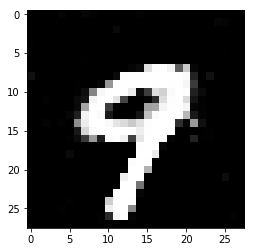

In [30]:
CG.eval()
z = torch.randn(1, code_len).to(device)
c = torch.zeros([1, 10]).to(device)
c[:, j] = 2
img = CG(z, c).view(1, 28, 28)
plt.imshow(img[0].cpu().data.numpy(), cmap="Greys_r", interpolation="none")

In [31]:
!ls ./samples

Conditional_GAN_step000.jpg   Simple_GAN_step000.jpg	Simple_GAN_step5000.jpg
Conditional_GAN_step5000.jpg  Simple_GAN_step10000.jpg


You can see that each row is a class and you have 10 examples of each class.

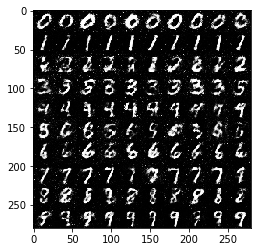

In [32]:
image = mpimg.imread('./samples/Conditional_GAN_step5000.jpg')
plt.imshow(image)

References:

https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/VanillaGAN.ipynb
https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/cgan/cgan.py



Deep Convolutional GAN: https://arxiv.org/pdf/1511.06434.pdf

In [0]:
#@title
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()   
        #in_channels, out_channels, k_size
        self.conv1 = nn.Conv2d(1,15,4, padding=2)
        self.conv2 = nn.Conv2d(15,15,4, dilation = 2)
        self.conv3 = nn.Conv2d(15,20,4, dilation = 2)
        self.maxp1= nn.MaxPool2d(2)
        self.maxp2 = nn.MaxPool2d(2)
        self.lr = nn.LeakyReLU(0.2)
        self.fc1 = nn.Linear(20+10, 40) 
        self.fc2 = nn.Linear(40, 1)        
        
    def forward(self, x, c):       
          x = x.view(x.shape[0],1, 28,28)
          x=self.conv1(x)
          x=self.lr(self.maxp1(x))
          #print(x.shape)
          x=self.conv2(x)
          x=self.lr(x)
          #print(x.shape)
          x=self.conv3(x)
          #print(x.shape)
          x=self.lr(self.maxp2(x))
          #print(x.shape)
          x = x.view(x.shape[0],20)
          x, c = x.view(x.size(0), -1), c.view(c.size(0), -1)
          v = torch.cat((x, c), 1)
          #print(v.shape)
          x=self.lr(self.fc1(v))
          x=self.fc2(x)          
          return torch.sigmoid(x)